# Sea Level Rise

### Eric Pham, Ylesia Wu, Zoe Ludena
### January 27, 2025

Models sea level rise as a function of temperature anomaly: dH/dt = a(T-T0) + e. From Rahmstorf 2007 paper. To run historical demo, need "global_basin_timeseries.xlsx" along with historical input TAS. To train SLR emulator model, gather TAS for outputs of ClimateBench models for each SSP, along with SLR_Training folder, which contains predicted SLR for 5th, 17th, 50th, 83rd, and 95th quantile. To run emulator model, provide TAS output from result of ClimateBench emulator.

In [2]:
'''Import Statements'''

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge

from eofs.xarray import Eof
from glob import glob

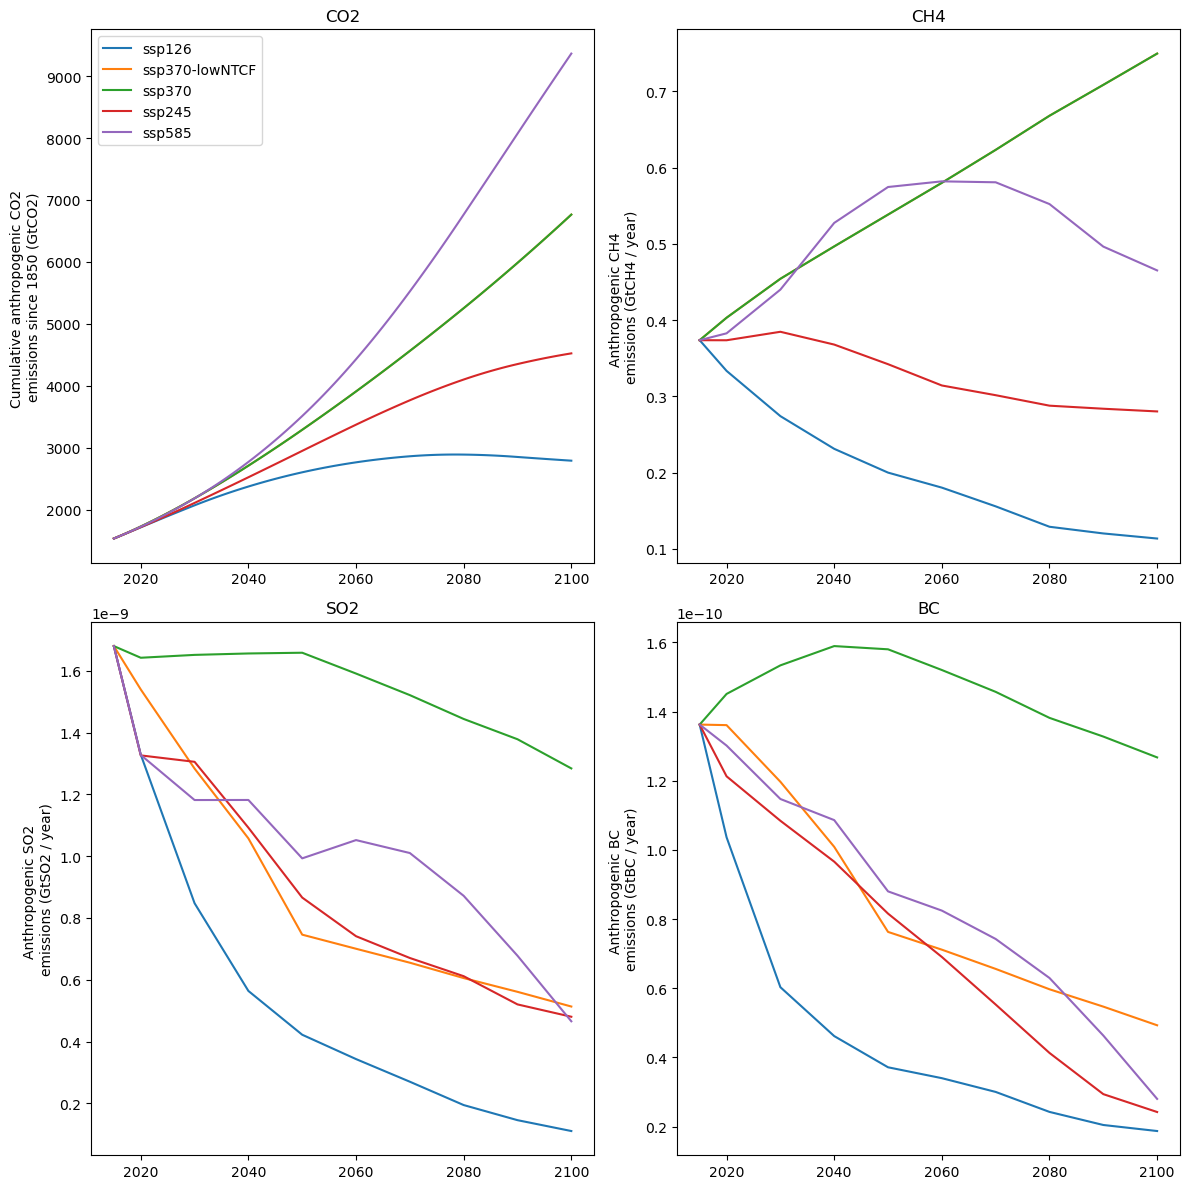

In [3]:
'''Process Emulator Inputs'''

# Change this path to where your emulator outputs are stored. We are training
# the SLR model on historical data and predicting on SSP data.
data_path = "ClimateBench/"

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    # Need this block and the next for the weights.
    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

In [17]:
'''More Input Processing'''

# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'), xr.open_dataset(data_path + 'inputs_ssp585.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc')], dim='time').compute()

# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st one for ssp585, ssp126, ssp370
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp126.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp370.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1,424) 
Y["time"]=np.arange(1,424)

# Need the weights here as well. Very important in order to weight
# the output file TAS variables.
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

historical_tas = xr.open_dataset("ClimateBench/outputs_historical.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp126_tas = xr.open_dataset("ClimateBench/outputs_ssp126.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp245_tas = xr.open_dataset("ClimateBench/outputs_ssp245.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp370_tas = xr.open_dataset("ClimateBench/outputs_ssp370.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp585_tas = xr.open_dataset("ClimateBench/outputs_ssp585.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()

## Model on Historical Satellite Data

The 2007 Rahmstorf's models performance trained on historical sea level rise using historical TAS shows that it can be a promising way of emulating sea level rise. This model will serve as the basis for emulated sea level rise in any ClimateBench scenario.

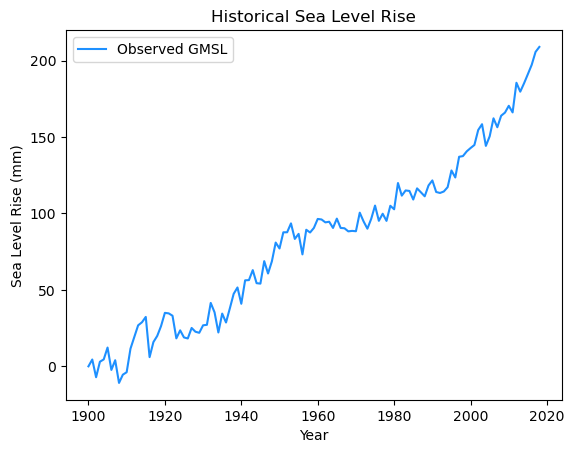

In [61]:
'''Plot of Historical Sea Level'''

# Read in SLR data.
more_sl = pd.read_excel("global_basin_timeseries.xlsx", index_col=0)
gmsl = more_sl[["Observed GMSL [mean]"]]
gmsl_anom = gmsl - gmsl.loc[1900]

plt.plot(gmsl_anom, label='Observed GMSL', color='dodgerblue', linestyle='-')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Historical Sea Level Rise')
plt.show()

The training MSE (historical only) is:  10.612898503759924


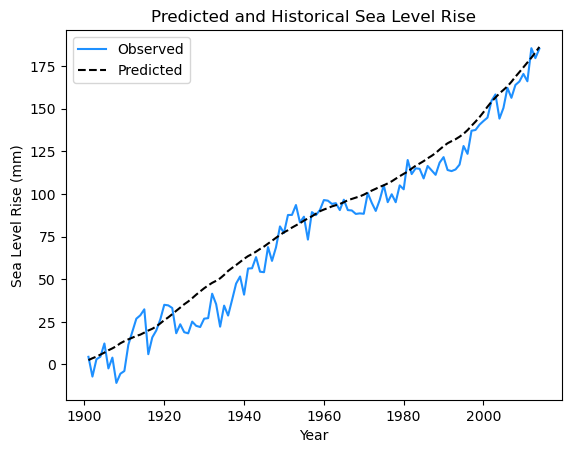

In [87]:
'''Fitting Rahmstorf 2007 Model on Historical'''

# Training historical data.
X_hist = historical_tas.loc[1901:2014].values.reshape(-1, 1)
y = gmsl_anom.diff().loc[1901:2014].values.reshape(-1, 1)

# Fit the linear regression model.
hist_model = LinearRegression()
hist_model.fit(X_hist, y)

# Predict and plot data.
hist_sl = pd.DataFrame({"year": range(1901, 2015), "pred dH_dt (mm/yr)": hist_model.predict(X_hist).flatten()})
hist_sl = hist_sl.set_index("year")
hist_sl = hist_sl.join(gmsl_anom, how='left')
hist_sl['pred_sea_level_rise'] = intercept + hist_sl['pred dH_dt (mm/yr)'].cumsum()

plt.plot(hist_sl['Observed GMSL [mean]'], 
         label='Observed', linestyle='-', color='dodgerblue')
plt.plot(hist_sl['pred_sea_level_rise'], 
         label='Predicted', linestyle='--', color='black')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Predicted and Historical Sea Level Rise')

# MSE for historical model performance.
MSE_TAS = sum((hist_sl['Observed GMSL [mean]'] - hist_sl['pred_sea_level_rise']) ** 2) / hist_sl.shape[0]
print("The training MSE (historical only) is: ", MSE_TAS ** 0.5)

plt.show()

## Validating on SSP 245

Now we train the same model using (TAS, rate of sea level rise) for all SSPs except 245, which we withhold for validation. We train a model for each quantile (5, 17, 50, 83, 95). Create an ensemble consisting of each quantile model.

In [75]:
'''Fitting Rahmstorf Model on SSP Data'''

# Features (temperature anomaly) and target (rate of sea level rise).
X_ssp126 = ssp126_tas.values.reshape(-1, 1)
X_ssp245 = ssp245_tas.values.reshape(-1, 1)
X_ssp370 = ssp370_tas.values.reshape(-1, 1)
X_ssp585 = ssp585_tas.values.reshape(-1, 1)

# ClimateBench output TAS.
df_126_tas = pd.DataFrame(ssp126_tas).reset_index().rename(columns={'time': 'year', 0: 'TAS'})
df_245_tas = pd.DataFrame(ssp245_tas).reset_index().rename(columns={'time': 'year', 0: 'TAS'})
df_370_tas = pd.DataFrame(ssp370_tas).reset_index().rename(columns={'time': 'year', 0: 'TAS'})
df_585_tas = pd.DataFrame(ssp585_tas).reset_index().rename(columns={'time': 'year', 0: 'TAS'})

In [77]:
'''5th Quantile Model'''

# 5th quantile.
data_5 = pd.read_csv('SLR_Training/5_quantile_yearly.csv')
data_5_ssp126 = df_126_tas.merge(data_5[['year', 'ssp126']]).rename(columns={'ssp126': 'GMSLR'})
data_5_ssp245 = df_245_tas.merge(data_5[['year', 'ssp245']]).rename(columns={'ssp245': 'GMSLR'})
data_5_ssp370 = df_370_tas.merge(data_5[['year', 'ssp370']]).rename(columns={'ssp370': 'GMSLR'})
data_5_ssp585 = df_585_tas.merge(data_5[['year', 'ssp585']]).rename(columns={'ssp585': 'GMSLR'})

# Training data.
data_5_train = pd.concat([data_5_ssp126, 
                           data_5_ssp370, 
                           data_5_ssp585], 
                          axis=0, 
                          ignore_index=True)
X_train_5 = data_5_train['TAS'].values.reshape(-1, 1)
y_train_5 = data_5_train['GMSLR'].values.reshape(-1, 1)

# Validation (SSP245) data.
X_val_5 = data_5_ssp245['TAS'].values.reshape(-1, 1)

# Model for 5th quantile.
model_5q = LinearRegression()
model_5q.fit(X_train_5, y_train_5)

val_5q = data_5_ssp245.set_index('year')
val_5q['pred_dH_dT'] = model_5q.predict(X_val_5)
val_5q['expected_SL'] = val_5q['GMSLR'].cumsum() * 1000
val_5q['predicted_SL'] = val_5q['pred_dH_dT'].cumsum() * 1000

In [78]:
'''17th Quantile Model'''

# 17th quantile.
data_17 = pd.read_csv('SLR_Training/17_quantile_yearly.csv')
data_17_ssp126 = df_126_tas.merge(data_17[['year', 'ssp126']]).rename(columns={'ssp126': 'GMSLR'})
data_17_ssp245 = df_245_tas.merge(data_17[['year', 'ssp245']]).rename(columns={'ssp245': 'GMSLR'})
data_17_ssp370 = df_370_tas.merge(data_17[['year', 'ssp370']]).rename(columns={'ssp370': 'GMSLR'})
data_17_ssp585 = df_585_tas.merge(data_17[['year', 'ssp585']]).rename(columns={'ssp585': 'GMSLR'})

# Training data.
data_17_train = pd.concat([data_17_ssp126, 
                           data_17_ssp370, 
                           data_17_ssp585], 
                          axis=0, 
                          ignore_index=True)
X_train_17 = data_17_train['TAS'].values.reshape(-1, 1)
y_train_17 = data_17_train['GMSLR'].values.reshape(-1, 1)

# Validation (SSP245) data.
X_val_17 = data_17_ssp245['TAS'].values.reshape(-1, 1)

# Model for 17th quantile.
model_17q = LinearRegression()
model_17q.fit(X_train_17, y_train_17)

val_17q = data_17_ssp245.set_index('year')
val_17q['pred_dH_dT'] = model_17q.predict(X_val_17)
val_17q['expected_SL'] = val_17q['GMSLR'].cumsum() * 1000
val_17q['predicted_SL'] = val_17q['pred_dH_dT'].cumsum() * 1000

In [79]:
'''50th Quantile Model'''

# 50th quantile.
data_50 = pd.read_csv('SLR_Training/50_quantile_yearly.csv')
data_50_ssp126 = df_126_tas.merge(data_50[['year', 'ssp126']]).rename(columns={'ssp126': 'GMSLR'})
data_50_ssp245 = df_245_tas.merge(data_50[['year', 'ssp245']]).rename(columns={'ssp245': 'GMSLR'})
data_50_ssp370 = df_370_tas.merge(data_50[['year', 'ssp370']]).rename(columns={'ssp370': 'GMSLR'})
data_50_ssp585 = df_585_tas.merge(data_50[['year', 'ssp585']]).rename(columns={'ssp585': 'GMSLR'})

# Training data.
data_50_train = pd.concat([data_50_ssp126, 
                           data_50_ssp370, 
                           data_50_ssp585], 
                          axis=0, 
                          ignore_index=True)
X_train_50 = data_50_train['TAS'].values.reshape(-1, 1)
y_train_50 = data_50_train['GMSLR'].values.reshape(-1, 1)

# Validation (SSP245) data.
X_val_50 = data_50_ssp245['TAS'].values.reshape(-1, 1)

# Model for 50th quantile.
model_50q = LinearRegression()
model_50q.fit(X_train_50, y_train_50)

val_50q = data_50_ssp245.set_index('year')
val_50q['pred_dH_dT'] = model_50q.predict(X_val_50)
val_50q['expected_SL'] = val_50q['GMSLR'].cumsum() * 1000
val_50q['predicted_SL'] = val_50q['pred_dH_dT'].cumsum() * 1000

In [80]:
'''83rd Quantile Model'''

# 83rd quantile.
data_83 = pd.read_csv('SLR_Training/83_quantile_yearly.csv')
data_83_ssp126 = df_126_tas.merge(data_83[['year', 'ssp126']]).rename(columns={'ssp126': 'GMSLR'})
data_83_ssp245 = df_245_tas.merge(data_83[['year', 'ssp245']]).rename(columns={'ssp245': 'GMSLR'})
data_83_ssp370 = df_370_tas.merge(data_83[['year', 'ssp370']]).rename(columns={'ssp370': 'GMSLR'})
data_83_ssp585 = df_585_tas.merge(data_83[['year', 'ssp585']]).rename(columns={'ssp585': 'GMSLR'})

# Training data.
data_83_train = pd.concat([data_83_ssp126, 
                           data_83_ssp370, 
                           data_83_ssp585], 
                          axis=0, 
                          ignore_index=True)
X_train_83 = data_83_train['TAS'].values.reshape(-1, 1)
y_train_83 = data_83_train['GMSLR'].values.reshape(-1, 1)

# Validation (SSP245) data.
X_val_83 = data_83_ssp245['TAS'].values.reshape(-1, 1)

# Model for 83th quantile.
model_83q = LinearRegression()
model_83q.fit(X_train_83, y_train_83)

val_83q = data_83_ssp245.set_index('year')
val_83q['pred_dH_dT'] = model_83q.predict(X_val_83)
val_83q['expected_SL'] = val_83q['GMSLR'].cumsum() * 1000
val_83q['predicted_SL'] = val_83q['pred_dH_dT'].cumsum() * 1000

In [81]:
'''95th Quantile Model'''

# 95th quantile.
data_95 = pd.read_csv('SLR_Training/95_quantile_yearly.csv')
data_95_ssp126 = df_126_tas.merge(data_95[['year', 'ssp126']]).rename(columns={'ssp126': 'GMSLR'})
data_95_ssp245 = df_245_tas.merge(data_95[['year', 'ssp245']]).rename(columns={'ssp245': 'GMSLR'})
data_95_ssp370 = df_370_tas.merge(data_95[['year', 'ssp370']]).rename(columns={'ssp370': 'GMSLR'})
data_95_ssp585 = df_585_tas.merge(data_95[['year', 'ssp585']]).rename(columns={'ssp585': 'GMSLR'})

# Training data.
data_95_train = pd.concat([data_95_ssp126, 
                           data_95_ssp370, 
                           data_95_ssp585], 
                          axis=0, 
                          ignore_index=True)
X_train_95 = data_95_train['TAS'].values.reshape(-1, 1)
y_train_95 = data_95_train['GMSLR'].values.reshape(-1, 1)

# Validation (SSP245) data.
X_val_95 = data_95_ssp245['TAS'].values.reshape(-1, 1)

# Model for 95th quantile.
model_95q = LinearRegression()
model_95q.fit(X_train_95, y_train_95)

val_95q = data_95_ssp245.set_index('year')
val_95q['pred_dH_dT'] = model_95q.predict(X_val_95)
val_95q['expected_SL'] = val_95q['GMSLR'].cumsum() * 1000
val_95q['predicted_SL'] = val_95q['pred_dH_dT'].cumsum() * 1000

The validation MSE (SSP245 only) is:  6.101069190216498


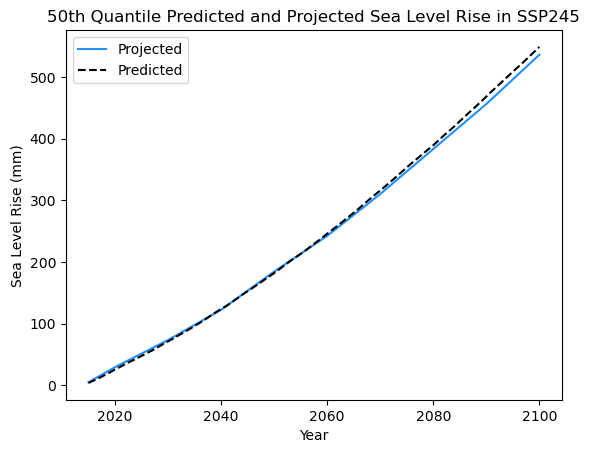

,TAS,GMSLR,pred_dH_dT,expected_SL,predicted_SL
year,,,,,
2015,0.724876,0.0049,0.003818,4.9,3.817832
2016,0.774634,0.0049,0.003970,9.8,7.787821
2017,0.792321,0.0049,0.004024,14.7,11.811895
2018,0.905029,0.0049,0.004369,19.6,16.180621
2019,0.987700,0.0049,0.004622,24.5,20.802149
...,...,...,...,...,...
2096,2.008961,0.0080,0.007744,504.4,516.603718
2097,2.022577,0.0080,0.007786,512.4,524.389820
2098,2.187471,0.0080,0.008290,520.4,532.680156


In [88]:
'''Plotting Validation'''

# MSE for historical model performance.
MSE_val = sum((val_50q['expected_SL'] - val_50q['predicted_SL']) ** 2) / val_50q.shape[0]
print("The validation MSE (SSP245 only) is: ", MSE_val ** 0.5)

# Plot of 50th quantile model.
plt.plot(val_50q['expected_SL'], 
         label='Projected', linestyle='-', color='dodgerblue')
plt.plot(val_50q['predicted_SL'], 
         label='Predicted', linestyle='--', color='black')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('50th Quantile Predicted and Projected Sea Level Rise in SSP245')
plt.show()

## Predicting with the SLR Emulator

In [ ]:
'''Taking in ClimateBench Emulator Outputs for Custom Scenarios'''

'''
custom_data = ### xr.open_dataset() /pd.read_csv() depending on format.

X_custom = custom_data['TAS'].values.reshape(-1, 1)

SLR_custom = pd.DataFrame({'year': np.arange(2015, 2101)})

SLR_custom['5q_dH_dT'] = model_5q(X_custom) ### IMPORTANT... if we don't want to go through the trouble 
SLR_custom['17q_dH_dT'] = model_17q(X_custom) ### of training each model, we can save the model weights
SLR_custom['50q_dH_dT'] = model_50q(X_custom) ### (intercept & slope) and just save those in a file and 
SLR_custom['83q_dH_dT'] = model_83q(X_custom) ### do the calculation manually, to make the app more 
SLR_custom['95q_dH_dT'] = model_95q(X_custom) ### more efficient.

SLR_custom = SLR_custom.set_index('year').cumsum() * 1000 <- if want in mm, otherwise remove.

'''